### Workbook to process medical CT images. 

#### Packages to run notebook

In [1]:
import os
import numpy as np
import SimpleITK as sitk

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from typing import List, Tuple, Dict, Union 

import pydicom

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
import tempfile
import os

import pandas as pd
from datetime import datetime, timedelta
import csv

from typing import List, Optional

import pandas as pd
from dateutil.relativedelta import relativedelta
import cv2
from matplotlib.patches import Circle



### Loading in files 

In [2]:
#finding directory 
def get_folder_names(exp: str, file_path):
    #Retrieve the names of the folders for the given experiment.
    def list_all_folders(exp_path: str) -> List[str]:
    #List all folders within the experiment path.
        return [f.name for f in os.scandir(exp_path) if f.is_dir()]

    exp_path = os.path.join(file_path, exp)
    folder_names = list_all_folders(exp_path)
    return folder_names, exp_path


def read_dicom_file(file_path: str) -> np.ndarray:
    #Read a DICOM file from the given path
    dicom_file = pydicom.dcmread(file_path, force = "True")
    dicom_file.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian  
        
    # Extract the date and time from the relevant DICOM tags
    study_date = dicom_file.get('StudyDate', 'Unknown')
    study_time = dicom_file.get('StudyTime', 'Unknown')
    series_date = dicom_file.get('SeriesDate', 'Unknown')
    series_time = dicom_file.get('SeriesTime', 'Unknown')
    acquisition_date = dicom_file.get('AcquisitionDate', 'Unknown')
    acquisition_time = dicom_file.get('AcquisitionTime', 'Unknown')

    # Combine date and time into a single string
    datetime_str = acquisition_date + acquisition_time
    datetime_format = "%Y%m%d%H%M%S"
    acquisition_datetime = datetime.strptime(datetime_str, datetime_format)
        
    return dicom_file.pixel_array.astype(float), acquisition_datetime


def find_center_coeff(image_array):
    # Normalize the pixel array to the range 0-255 (optional, depending on the image characteristics)
    image_array = (np.maximum(image_array, 0) / image_array.max()) * 255.0
    image_array = np.uint8(image_array)

    # Ensure the image array is not empty and is in the correct format
    if image_array is None or image_array.size == 0:
        print("Error: The image array is empty or not defined correctly")
    else:
        # Convert to 3-channel BGR if necessary (assuming the image array is grayscale)
        if len(image_array.shape) == 2:
            gray = image_array
        else:
            gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

        # Use Hough Circle Transform to detect the circle
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=50, minRadius=140, maxRadius=190)
        # Get the dimensions of the image
        height, width = gray.shape
        

        # Ensure at least one circle was found
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")

            # Get the coordinates of the detected circle
            for (x, y, r) in circles:
                circle_center_x = x
                circle_center_y = y
                print(f"Offset to center the circle: (x: {circle_center_x}, y: {circle_center_y})")

                if r < 100 or r> 300:
                    print('Incorrect circle radii found')
        else:
            print("No circles were found")
    return circle_center_x, circle_center_y


def center_rock_sample(image: np.ndarray, cy: int, cx: int, cr: int) -> np.ndarray:
    #centering correction 
    nr, nc = image.shape
    yy, xx = np.meshgrid(range(1, nr + 1), range(1, nc + 1), indexing='ij')
    c_mask = ((yy - cy) ** 2 + (xx - cx) ** 2 <= cr ** 2)
    dummy = np.ones_like(image)
    dummy *= c_mask
    dummy[dummy == 0] = np.nan
    centered_image = image * dummy
    return centered_image

def find_center_list(path_to_files: List[str], folder_name: List[str], start_slice, num_slices, cr): 
    os.chdir(os.path.join(path_to_files, folder_name))
    image_names = os.listdir()

    im_num1 = start_slice + 5
    im_num2 = start_slice + num_slices - 5

    #find centering parameters
    slice1, slice1_time = read_dicom_file(image_names[im_num1])
    slice2, slice2_time = read_dicom_file(image_names[im_num2])
    cx1, cy1 = find_center_coeff(slice1)
    cx2, cy2 = find_center_coeff(slice2)

    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    image1_wet = center_rock_sample(slice1, cy=cy1, cx=cx1, cr=cr)
    axes[0].imshow(image1_wet)
    axes[0].add_patch(Circle((cx1, cy1), cr, fill=False, linestyle='--', color='r'))
    axes[0].add_patch(Circle((cx1, cy1), cr+20, fill=False, linestyle='--', color='k'))
    axes[0].set_title('Image 1')
    axes[0].set_ylabel('cx')
    axes[0].set_xlabel('cy')


    image2_wet = center_rock_sample(slice2, cx=cy2, cy=cx2, cr=cr)
    axes[1].imshow(image2_wet)
    axes[1].add_patch(Circle((cx2, cy2), cr, fill=False, linestyle='--', color='r'))
    axes[1].add_patch(Circle((cx2, cy2), cr+20, fill=False, linestyle='--', color='k'))
    axes[1].set_title('Image 2')
    plt.tight_layout()
    plt.show()
    

    ### calculating centering points for the image correction 
    slope_cx = (cx2 - cx1) / (num_slices - 1)
    Intpt_cx = cx1 - slope_cx
    slope_cy = (cy1 -cy2) / (num_slices - 1)
    Intpt_cy = cy2 - slope_cy

    cx = [round(slope_cx * i + Intpt_cx) for i in range(1, num_slices + 1)]
    cy = [round(slope_cy * i + Intpt_cy) for i in range(1, num_slices + 1)]
    

    return cx, cy



#load in images and correct for any slope between intial and final scan 
def load_process_scan(path_to_files: List[str], folder_name: List[str], start_slice: int, num_slices:int, cr: int) -> Tuple[np.ndarray, List[float]]:
    """
    Process flow scans by reading DICOM files, averaging, masking, reorienting, and calculating CT numbers.

    Args:
        file_paths (List[str]): List of file paths to the DICOM files.
        cx_list (List[int]): List of center x-coordinates.
        cy_list (List[int]): List of center y-coordinates.
        cr (int): Radius for masking.

    Returns:
        Tuple[np.ndarray, List[float]]: Tuple containing the processed 3D image array and slice-averaged CT numbers.
    """
    #change directory to one of interest 
    os.chdir(os.path.join(path_to_files, folder_name))
    image_names = os.listdir()
    images_to_process = image_names[start_slice:start_slice + num_slices]

    cx_list, cy_list = find_center_list(path_to_files, folder_name, start_slice, num_slices, cr)



    processed_images = []
    ct_numbers = []
    for kk, file_path in enumerate(reversed(images_to_process)):
        cx, cy = cx_list[kk], cy_list[kk]
        image, time = read_dicom_file(file_path)
        centered_image = center_rock_sample(image, cx, cy, cr)
        processed_images.append(centered_image)
        ct_number = np.nanmean(centered_image)
        ct_numbers.append(ct_number)

    print(folder_name)
    return np.array(processed_images), ct_numbers, time

def averaging_scans(path_to_files: List[str], folder_name: List[str], no_scans: int, start_slice:int, num_slices: int, cx_list: List[int], cy_list: List[int], cr: int): 
    #average multiple scans
    processed_images_all = [] 

    for i in range(start_slice, no_scans*num_slices, num_slices):
        print(i)
        processed_images, ct_numbers = load_process_scan(path_to_files, folder_name, i, num_slices, cx_list, cy_list, cr = input_parameters['cr'])
        processed_images_all.append(processed_images)
        plt.plot(ct_numbers[15:-15])
    plt.ylabel('CT number')
    plt.xlabel('Slice number')

    average_scans = np.mean(processed_images_all, axis=0)
    return average_scans

### Processing functions

In [3]:
def apply_coarsening(image: np.ndarray, coarse: int) -> np.ndarray:
    # Reshape the image to apply coarsening
    shape = (image.shape[0] // coarse, coarse, image.shape[1] // coarse, coarse)
    coarsened_image = image.reshape(shape).mean(-1).mean(1)
    return coarsened_image

def calculate_porosity(image_dry: np.ndarray, image_wet: np.ndarray, CT_water: float, CT_air: float, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """

    images_porosity              = (image_wet - image_dry) / (CT_water - CT_air) 
    voxel_porosity_coarsened     = [apply_coarsening(image, coarse) for image in images_porosity]
    slice_averaged_porosity      = [np.nanmean(image) for image in voxel_porosity_coarsened] #ignoring voxels  < 0
    core_averaged_porosity       = np.nanmean(slice_averaged_porosity[rockin:rockout])
    voxel_porosity_coarsened     = np.array(voxel_porosity_coarsened)
    return voxel_porosity_coarsened[rockin:rockout, ...], core_averaged_porosity, slice_averaged_porosity[rockin:rockout] 


def calculate_saturation(image_flow: np.ndarray, image_wet: np.ndarray, porosity_voxels: np.ndarray, porosity: np.ndarray, CT_water: float, CT_air: float, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """

    images_sat              = (image_flow-image_wet) / (CT_air-CT_water) 
    voxel_sat_coarsened     = [apply_coarsening(image, coarse) for image in images_sat]
    voxel_sat_coarsened     = np.array(voxel_sat_coarsened)
    voxel_sat_coarsened     = voxel_sat_coarsened[rockin:rockout, ...] 
    voxel_sat_coarsened[voxel_sat_coarsened < 0] = 0  #values < 0 are assigned as 0 
    slice_averaged_sat      = [np.nanmean(image) for image in voxel_sat_coarsened]
    slice_averaged_sat      = [a / b for a, b in zip(slice_averaged_sat, porosity)]
    voxel_sat_coarsened     = voxel_sat_coarsened/porosity_voxels
    core_averaged_sat       = np.nanmean(slice_averaged_sat)
    print('The average saturation for the core is', core_averaged_sat)
    return voxel_sat_coarsened, core_averaged_sat, slice_averaged_sat


def calculate_saturation_CO2(image_flow: np.ndarray, image_wet: np.ndarray, image_CO2sat: np.ndarray, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """

    single_phase_subtract   =  image_CO2sat -image_wet
    single_phase_subtract[single_phase_subtract==0]   = np.inf
    images_sat              = (image_flow-image_wet) / single_phase_subtract
    voxel_sat_coarsened     = [apply_coarsening(image, coarse) for image in images_sat]
    voxel_sat_coarsened     = np.array(voxel_sat_coarsened)
    voxel_sat_coarsened     = voxel_sat_coarsened[rockin:rockout, ...] 
    voxel_sat_coarsened[voxel_sat_coarsened < 0] = 0       #values < 0 are assigned as 0 
    slice_averaged_sat      = [np.nanmean(image) for image in voxel_sat_coarsened]
    core_averaged_sat       = np.nanmean(slice_averaged_sat)
    print('The average saturation for the core is', core_averaged_sat)
    return voxel_sat_coarsened, core_averaged_sat, slice_averaged_sat


def plot_slice_averaged_profiles(slice_averaged: List[float], label: str, title: str, marker: Optional[str] = None) -> None:
    size_slice = 0.0625 
    """
    Plot slice-averaged profiles for porosity and CT numbers.

    Args:
        slice_averaged_porosity (List[float]): Slice-averaged porosity values.
        ct_numbers (List[float]): CT numbers for the slices.
        label (str): Label for the plot.
        title (str): Title for the plot.
        marker (Optional[str]): Marker shape for the plot (default is None).
    """
    if marker:
        plt.plot(np.linspace(0, len(slice_averaged)*size_slice, num=len(slice_averaged)), slice_averaged, label=label, marker=marker, markersize=5)
    else:
        plt.plot(np.linspace(0, len(slice_averaged)*size_slice, num=len(slice_averaged)), slice_averaged, label=label)
        
    plt.legend(fontsize='12')
    plt.title(title, loc='left', fontsize='16')
    plt.xlabel("Distance from inlet (cm)", fontsize='14')
    plt.ylabel("Gas saturation", fontsize='14')


### Visualisation 

In [4]:

def voxel_map_3D(saturation_voxels, input,  v_min, v_max):
    x= saturation_voxels
    v_min = v_min
    v_max = v_max
    down_sample_rate_widget = IntSlider(min=1, max=5, step=1, value=1, description='Downsample Rate:')
    alpha_widget = FloatSlider(min=0, max=1, step=0.1, value=1, description='Opacity:')
    slice_dim_widget = Dropdown(options=[None, 'x', 'y', 'z', 'segment'], value='segment', description='Slice Dimension:')
    slice_pos_widget = IntSlider(min=0, max=input_parameters['rockout'] - 1, step=1, value=0, description='Slice Position:')
    azimuth_widget = IntSlider(min=0, max=360, step=1, value=51, description='Azimuth:')

    def plot_voxels(down_sample_rate=0, alpha=1.0, slice_dim=None, slice_pos=0, azimuth=90):
        plt.close()
        

        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        x_downsampled = x[::down_sample_rate, ::down_sample_rate, ::down_sample_rate]
        
        if slice_dim is None:
            i, j, k = np.where(x_downsampled >= -np.inf)
            color_data = x_downsampled[i, j, k]
        else:
            if slice_dim == 'x':
                i = np.array([slice_pos] * x_downsampled.shape[1] * x_downsampled.shape[2])
                j, k = np.meshgrid(np.arange(x_downsampled.shape[1]), np.arange(x_downsampled.shape[2]))
            elif slice_dim == 'y':
                j = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[2])
                i, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[2]))
            elif slice_dim == 'z':
                k = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[1])
                i, j = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[1]))
            elif slice_dim == 'segment':
                i, j, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(round(x_downsampled.shape[1]/2)), np.arange(x_downsampled.shape[2]))
            
            i, j, k = i.flatten(), j.flatten(), k.flatten()
            color_data = x_downsampled[i, j, k]
        
        sc = ax.scatter(i, j, k, c=color_data, cmap='viridis', marker='s',  vmin=v_min, vmax=v_max, alpha=alpha)
        
        ax.view_init(azim=azimuth)

        ax.set_xlim([0, x_downsampled.shape[0]*0.7])
        ax.set_ylim([0, x_downsampled.shape[1]*0.7])
        ax.set_zlim([0, x_downsampled.shape[2]*0.7])
        ax.axis('off') #remove the grid lines 
 

        cbar = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
        cbar.set_label(input, rotation=-90, labelpad=15)  # Set the label and rotation
        cbar.ax.set_position([0.8, 0.4, 0.02, 0.4]) 
        custom_filename = "E:\\Medical_CT\\" + str(input) + ".png"
        #plt.savefig(custom_filename)

    def update(frame, ax):
        if frame < 180:  # Phase 1: rotation
            print(f"Rotating, Frame: {frame}")  # debugging
            azimuth = frame
            plot_voxels(azimuth=azimuth, ax=ax)
        elif frame < 180 + x.shape[0]:  # Phase 2: slicing
            slice_pos = frame - 180
            print(f"Slicing, Frame: {frame}, Slice Position: {slice_pos}")  # debugging
            plot_voxels(slice_dim='x', slice_pos=slice_pos, ax=ax)

    '''
    with tempfile.TemporaryDirectory() as tmpdirname:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ani = FuncAnimation(fig, update, frames=np.arange(0, 180 + x.shape[0]), fargs=(ax,))

        frames = []
        durations = []
        
        for i in range(ani.save_count):
            ani._draw_frame(i)
            frame_path = os.path.join(tmpdirname, f"frame_{i}.png")
            plt.savefig(frame_path)
            frames.append(Image.open(frame_path))
            
            if i < 180:  # rotation phase
                durations.append(150)
            else:  # slicing phase
                durations.append(1000)

        frames[0].save(
            'rotation_and_slice.gif',
            save_all=True,
            append_images=frames[1:],
            loop=0,
            duration=durations,
        )'''
        
    interact(
    plot_voxels,
    down_sample_rate=down_sample_rate_widget,
    alpha=alpha_widget,
    slice_dim=slice_dim_widget,
    slice_pos=slice_pos_widget,
    azimuth = azimuth_widget
    )    


### Example 

Offset to center the circle: (x: 295, y: 278)
Offset to center the circle: (x: 281, y: 281)


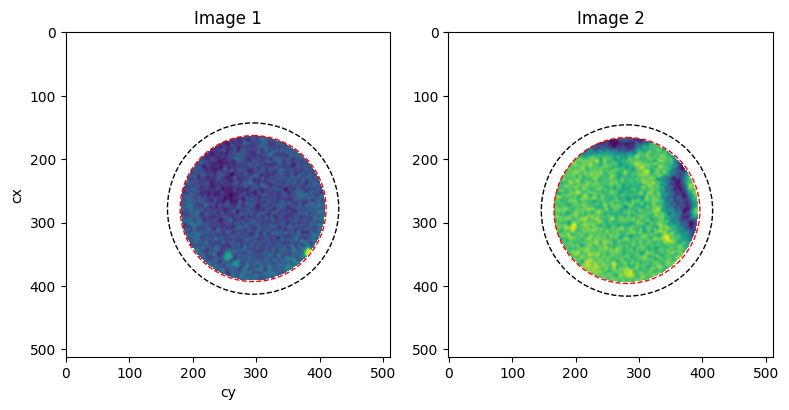

wet
Offset to center the circle: (x: 293, y: 279)
Offset to center the circle: (x: 283, y: 281)


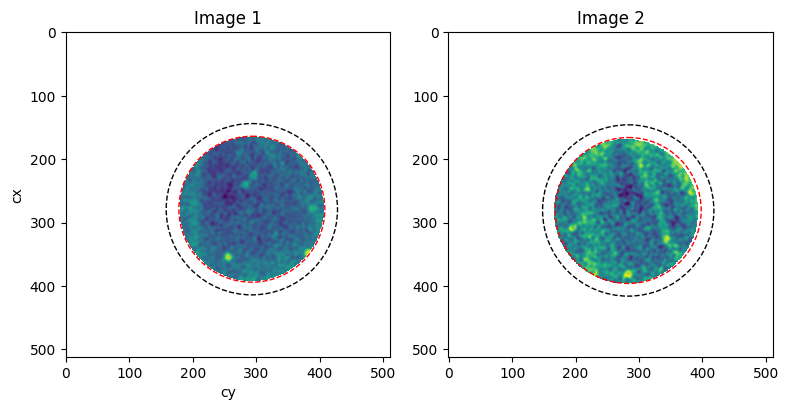

dry
The average porosity is 0.34302086561202166


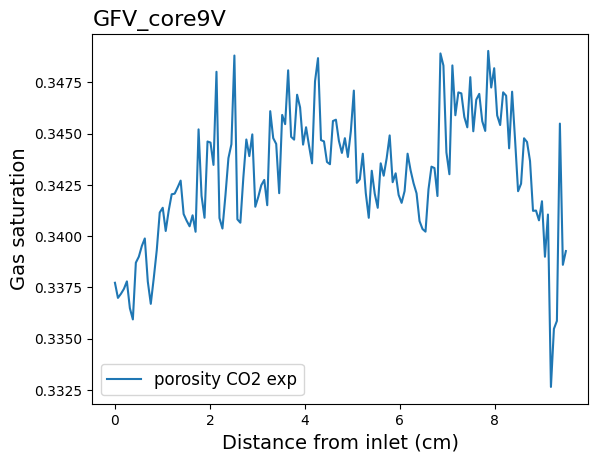

interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

Offset to center the circle: (x: 290, y: 278)
Offset to center the circle: (x: 280, y: 279)


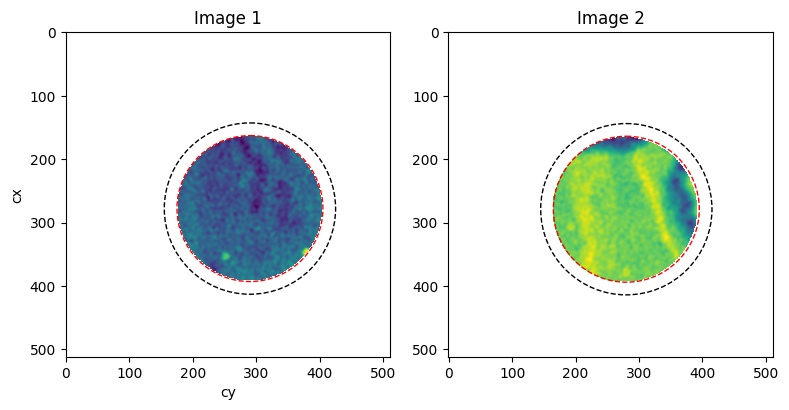

exp
The average saturation for the core is 0.25799964465711495
Offset to center the circle: (x: 290, y: 278)
Offset to center the circle: (x: 280, y: 279)


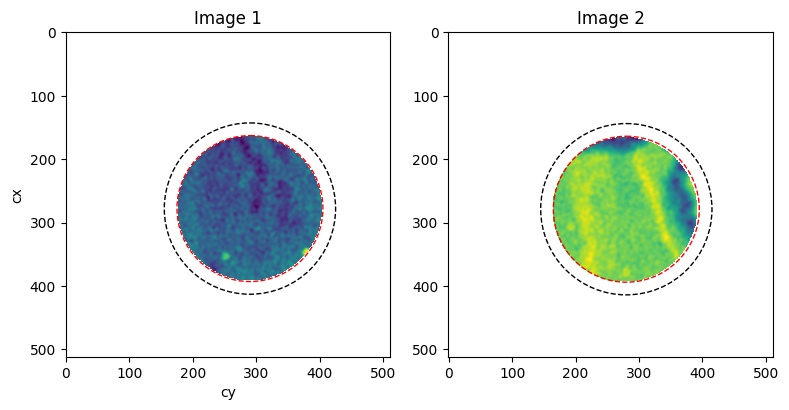

exp
The average saturation for the core is 0.22703968729826113


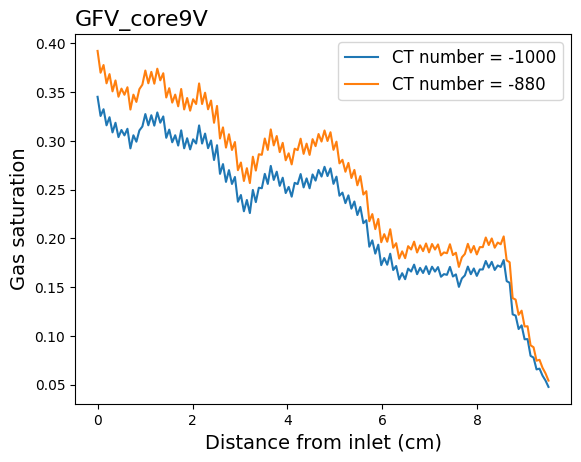

interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

In [9]:
file_path = "E:\\Otway_cores\\"
exp = 'GFV_core9V'


#input parameters 
input_parameters = {
    'CT_water': 0,
    'CT_air': -1000,
    'coarse': 4,
    'rockin': 10,
    'rockout': 162,
    'num_slices': 166,
    'Slicethick': 0.625,
    'Voxsize': 0.1875,
    'cr': 115
}


folder_names, path_to_files = get_folder_names(exp, file_path)
processed_images_wet, ct_numbers_wet, time_wet = load_process_scan(path_to_files, 
                                                                   "wet", 
                                                                   0, 
                                                                   input_parameters['num_slices'],  
                                                                   cr = input_parameters['cr'])

processed_images_dry, ct_numbers_dry, time_dry = load_process_scan(path_to_files, 
                                                                   "dry", 
                                                                   0, 
                                                                   input_parameters['num_slices'],  
                                                                   cr = input_parameters['cr'])

porosity_voxels, core_averaged_porosity, slice_averaged_porosity = calculate_porosity(processed_images_dry,
                                                                                      processed_images_wet, 
                                                                                      CT_water = input_parameters['CT_water'], 
                                                                                      CT_air = input_parameters['CT_air'], 
                                                                                      coarse = input_parameters['coarse'], 
                                                                                      rockin = input_parameters['rockin'], 
                                                                                      rockout = input_parameters['rockout'])


plot_slice_averaged_profiles(slice_averaged_porosity, 'porosity CO2 exp', exp)

print('The average porosity is', np.mean(slice_averaged_porosity))
plt.show()

voxel_map_3D(porosity_voxels, 'Porosity', 0,  1)


processed_images, ct_numbers, time_scan = load_process_scan(path_to_files, "exp", 3652, input_parameters['num_slices'], cr=input_parameters['cr'])
saturation_voxels, core_averaged_sat, slice_averaged_sat_880 = calculate_saturation(processed_images, 
                                                                                    processed_images_wet, 
                                                                                    porosity_voxels, 
                                                                                    slice_averaged_porosity, 
                                                                                    CT_water=input_parameters['CT_water'], 
                                                                                    CT_air = -880, 
                                                                                    coarse=input_parameters['coarse'], 
                                                                                    rockin=input_parameters['rockin'], 
                                                                                    rockout=input_parameters['rockout'])




processed_images, ct_numbers,  time_scan = load_process_scan(path_to_files, "exp", 3652, input_parameters['num_slices'],  cr=input_parameters['cr'])
saturation_voxels, core_averaged_sat, slice_averaged_sat_1000 = calculate_saturation(processed_images, 
                                                                                    processed_images_wet, 
                                                                                    porosity_voxels, 
                                                                                    slice_averaged_porosity, 
                                                                                    CT_water=input_parameters['CT_water'], 
                                                                                    CT_air = -1000, 
                                                                                    coarse=input_parameters['coarse'], 
                                                                                    rockin=input_parameters['rockin'], 
                                                                                    rockout=input_parameters['rockout'])


plot_slice_averaged_profiles(slice_averaged_sat_1000, 'CT number = -1000', exp)
plot_slice_averaged_profiles(slice_averaged_sat_880, 'CT number = -880', exp)

voxel_map_3D(saturation_voxels, 'Gas saturation', 0,  0.5)


### Pressure transducer data

In [6]:
# Loading pressure transducer data
pump_data1 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_18-Jan-2024_15_24_47.txt', header=None)
pump_data2 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_19-Jan-2024_12_31_06.txt', header=None)
pump_data3 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_21-Jan-2024_13_12_21.txt', header=None)
pump_data4 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_23-Jan-2024_14_10_04.txt', header=None)
pump_data5 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_24-Jan-2024_13_25_30.txt', header=None)
pump_data6 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_25-Jan-2024_08_31_56.txt', header=None)
pump_data7 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_30-Jan-2024_09_12_55.txt', header=None)
pump_data8 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_31-Jan-2024_18_26_37.txt', header=None)
pump_data9 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_02-Feb-2024_12_37_46.txt', header=None)
pump_data10 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_05-Feb-2024_11_20_31.txt', header=None)

pump_data11 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_07-Feb-2024_19_49_26.txt', header=None)
pump_data12 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_08-Feb-2024_15_47_51.txt', header=None)
pump_data13 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_12-Feb-2024_12_22_00.txt', header=None)
pump_data14 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_13-Feb-2024_14_18_38.txt', header=None)
pump_data15 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_29-Feb-2024_11_07_19.txt', header=None)
pump_data16 = pd.read_table(r'E:\Otway_cores\pressure_GFV\prexp_04-Mar-2024_09_36_51.txt', header=None)

# Combining pressure data
pressure_data = pd.concat([pump_data1, pump_data2, pump_data3, pump_data4, pump_data5, pump_data6, pump_data7, pump_data8, pump_data9, pump_data10, pump_data11, pump_data12, pump_data13, pump_data14, pump_data15, pump_data16])


### Analysing pressure data 

In [7]:

def pressure_analysis(time_exp, end_exp, pressure_data, labels):
    '''Plots the pressure during an experiment 
    time_exp      = datetime, start of experiment
    end_exp       = datetime, end of experiment 
    pressure_data = data from the pressure transducer 
    separate_plot = if you want the pressure to plot as a single plot = False, and if you want separate plots = True 
    '''
    first_day = datetime(1, 1, 1, 0, 0, 0)   # starting date for the transducer time format
    psi2kpa = 6.89476  # conversion of psi to kpa
    correction_between_transducers = 1.05 #psi
    time     = first_day + np.array([timedelta(days=d) for d in pressure_data.iloc[:, 0]]) - relativedelta(years=1, days=1) #need to subtract an extra year and day to fit with matlab saving 
    pressure = pressure_data.iloc[:, 1] - 710 #pressure_data.iloc[:, 2]  + correction_between_transducers
    mean_pressure = [] 

    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title('Click on legend line to toggle line on/off')
    lines =[]
        
    time_start = time_exp
    time_end = end_exp

    time_plot = time[(time >= time_start) & (time <= time_end)]
    time_plot_minutes = (time_plot - np.array(time_start))
    time_plot_minutes = [t.total_seconds()/60 for t in time_plot_minutes]
    pressure_plot = pressure[(time >= time_start) & (time <= time_end)]
    (line1, ) = ax.plot(time_plot_minutes , pressure_plot * psi2kpa, lw=2, label=labels)
    plt.xlabel('Time (mins)')
    plt.ylabel('Differential pressure (kPa)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    mean_pressure.append(np.mean(pressure_plot * psi2kpa))
    lines.append(line1)

    leg = ax.legend(fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1.5, 0.5))
    
    map_legend_to_ax = {} 

    pickradius = 5  # Points (Pt). How close the click needs to be to trigger an event.

    for legend_line, ax_line in zip(leg.get_lines(), lines):
        legend_line.set_picker(pickradius)  # Enable picking on the legend line.
        map_legend_to_ax[legend_line] = ax_line


    def on_pick(event):
        # On the pick event, find the original line corresponding to the legend
        # proxy line, and toggle its visibility.
        legend_line = event.artist

        # Do nothing if the source of the event is not a legend line.
        if legend_line not in map_legend_to_ax:
            return

        ax_line = map_legend_to_ax[legend_line]
        visible = not ax_line.get_visible()
        ax_line.set_visible(visible)
        legend_line.set_alpha(1.0 if visible else 0.2)    # Change the alpha on the line in the legend
        fig.canvas.draw()

    fig.canvas.mpl_connect('pick_event', on_pick)
    plt.tight_layout()
    plt.show()

    return mean_pressure



def perm_calc(pressure_data, time_exp, flow_rates, time_int, transducer_error, length_sample):
    first_day = first_day = datetime(1, 1, 1, 0, 0, 0)   # starting date for the transducer time format
    psi2kpa = 6.89476  # conversion of psi to kpa
    correction_between_transducers = 1.05 #psi
    time     = first_day + np.array([timedelta(days=d) for d in pressure_data.iloc[:, 0]]) - relativedelta(years=1, days=1) #need to subtract an extra year and day to fit with matlab saving 
    pressure = pressure_data.iloc[:, 1] 
    diff_pressure   = pressure_data.iloc[:, 1] - pressure_data.iloc[:, 2] + correction_between_transducers # currently shifted 1 value
    pressure_outlet = pressure_data.iloc[:, 2]
    mean_pressure = [] 

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax = ax.flatten()

    
    # Plot correction
    pressure_correction = pressure_outlet[(time >= time_exp[0] - timedelta(minutes=10)) & (time <= time_exp[0])]
    pressure_correction2 = pressure[(time >= time_exp[0] - timedelta(minutes=10)) & (time <= time_exp[0])]
    ax[0].plot(pressure_correction * psi2kpa, '-', linewidth=1.5)
    ax[0].plot((pressure_correction2) * psi2kpa, '-', linewidth=1.5)
    ax[0].set_title('Pressure pre flow')
    ax[0].set_xlabel('Time (mins)')
    ax[0].set_ylabel('Pressure (kPa)')


    for i in range(len(time_exp)):
        time_exp[i]       = time_exp[i] + timedelta(minutes= transducer_error)  #transducer computer 1 minute out
        time_end          = time_exp[i] + timedelta(minutes=time_int)
        time_plot         = time[(time >= time_exp[i]) & (time <= time_end)]
        time_plot_minutes = (time_plot - np.array(time_exp[i]))
        time_plot_minutes = [t.total_seconds()/60 for t in time_plot_minutes]
        pressure_plot  = pressure[(time >= time_exp[i]) & (time <= time_end)]

        # Plot inlet pressure
        ax[1].plot(time_plot_minutes, pressure_plot  * psi2kpa, '-', linewidth=1.5)
        ax[1].set_title('Inlet Pressure')
        ax[1].set_xlabel('Time (mins)')
        ax[1].set_ylabel('Pressure (kPa)')

        # Plot outlet pressure
        pressure_outlet_plot = pressure_outlet[(time >= time_exp[i]) & (time <= time_end)]

        ax[2].plot(time_plot_minutes, pressure_outlet_plot * psi2kpa, '-', linewidth=1.5)
        ax[2].set_title('Outlet Pressure')
        ax[2].set_xlabel('Time (mins)')
        ax[2].set_ylabel('Pressure (kPa)')

 
        # Plot differential pressure 
        pressure_diff_plot = diff_pressure[(time >= time_exp[i]) & (time <= time_end)]
        ax[3].plot(time_plot_minutes, pressure_diff_plot  * psi2kpa, '-', linewidth=1.5)
        ax[3].set_title('Differential Pressure, subtraction')
        ax[3].set_xlabel('Time (mins)')
        ax[3].set_ylabel('Pressure (kPa)')
    
        mean_pressure.append(np.mean(pressure_diff_plot * psi2kpa* 10**3))


 
    # absolute permeability (porosity not used in this)
    mu_w = 8.9 * 10**(-4)  # viscosity of water in Pa.s
    A = np.pi * (2.5 * 10**(-2))**2  # diameter of rock, 5cm
    L = length_sample * 10**(-2)  # length of rock in cm
    q = flow_rates * 60**(-1) * 10**(-6)  # conversion of ml/min to m3/s

    k = ((q / mean_pressure) * mu_w * L) / A
    print(k * 10**15)
    print(f'The mean abs permeability is {np.mean(k * 10**15):.2f} mD')



### Pressure during scan

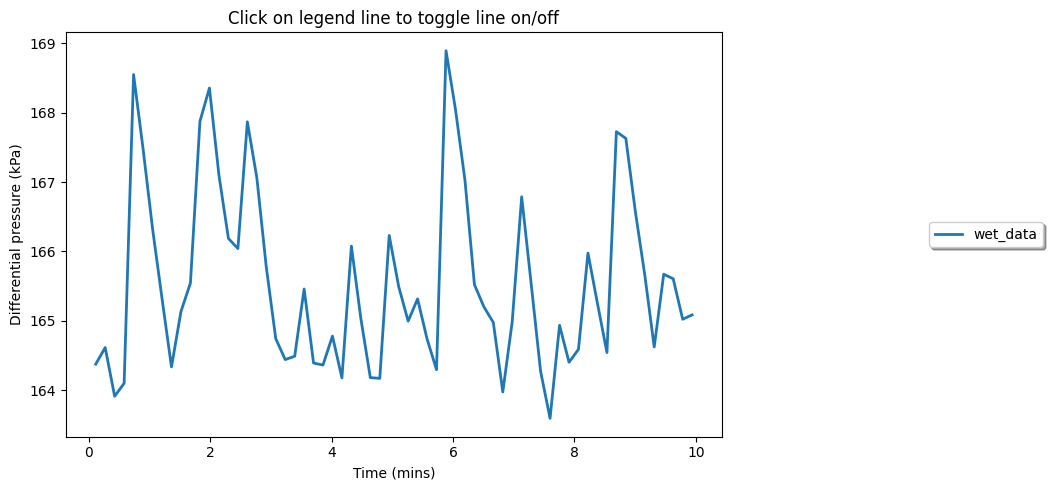

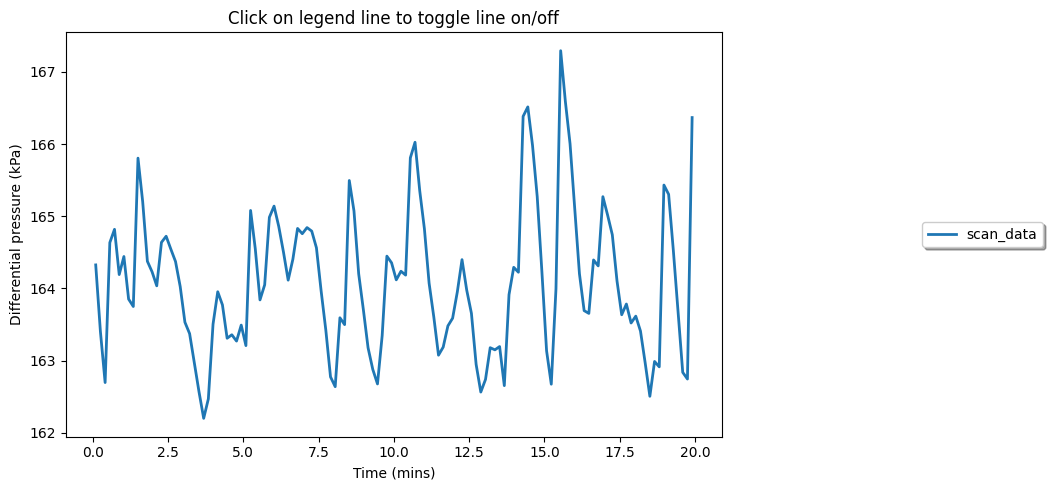

In [14]:

pressure_GFV_9V_wet  = pressure_analysis(time_exp = time_wet + timedelta(days=1), end_exp = time_wet + timedelta(minutes=10) + timedelta(days=1), pressure_data = pressure_data, labels='wet_data' )

pressure_GFV_9V      = pressure_analysis(time_exp = time_scan - timedelta(minutes=10), end_exp = time_scan + timedelta(minutes=10) , pressure_data = pressure_data, labels='scan_data' )

